In [48]:
from kural_core.imports import *
%reload_ext autoreload
%autoreload 2
%matplotlib inline
plt.rcParams['figure.figsize'] = (12, 12)
PATH_cm = r'F:\Movies_from_server_for_Josh\190509_SUM_AP2_plated_at_1030\\'
# MOVIE_FILE = '488nm_100p_50ms_1um_2hr_200xy_5z-MaxIP.nd2'
PATH = r'F:\Movies_from_server_for_Josh\190520_SUM_AP2_plated_at_1530\\'
MOVIE_FILE = 'lots_of_z_stacks.nd2'

In [2]:
img_stream = ND2Reader(PATH+MOVIE_FILE)

C:\Users\joshu\Miniconda3\envs\torch_env\lib\site-packages\nd2reader\common_raw_metadata.py:94: RuntimeWarning: Reported average frame interval (10799735.9 ms) doesn't match the set interval (10800000.0 ms). Using the average now.
  warnings.warn(message % (avg_interval, interval), RuntimeWarning)


In [8]:
img_stream.metadata.keys()

dict_keys(['height', 'width', 'date', 'fields_of_view', 'frames', 'z_levels', 'total_images_per_channel', 'channels', 'pixel_microns', 'num_frames', 'experiment'])

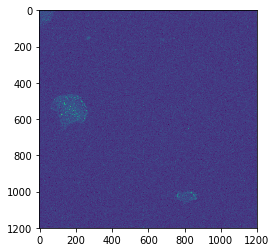

In [25]:
r_fov = choice(img_stream.metadata['fields_of_view'])
r_f = choice(img_stream.metadata['frames'])
r_z = choice(img_stream.metadata['z_levels'])
img = img_stream.get_frame_2D(t=r_f, v=r_fov, z=r_z)
plt.imshow(img)
plt.show()

In [36]:
img_list = []
coverage_list = []

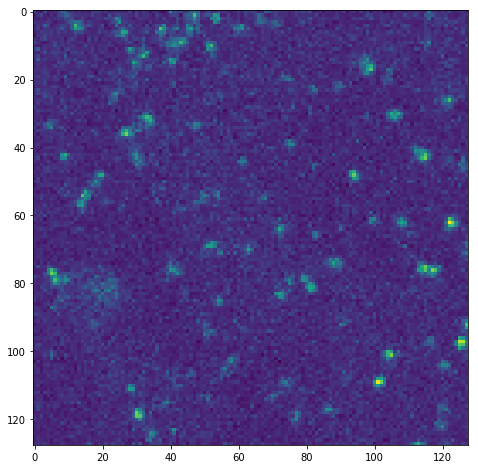

coverage score: -1


In [8]:
while True:
    fig = plt.figure(figsize=(8,8))
    rfov = choice(img_stream.metadata['fields_of_view'])
    rf = choice(img_stream.metadata['frames'])
    img = img_stream.get_frame_2D(t=rf, v=rfov)
    rx = choice(1200-128)
    ry = choice(1200-128)
    tmp_img = img[ry:ry+128, rx:rx+128].astype(np.float32)
    clear_output(True)
    plt.imshow(tmp_img)
    plt.show()
    coverage = float(input('coverage score: '))/10
    if coverage<0: break
    coverage_list.append(coverage)
    tmp_img = torch.tensor(tmp_img)
    tmp_img = (tmp_img-tmp_img.mean())/tmp_img.std()
    img_list.append(tmp_img)

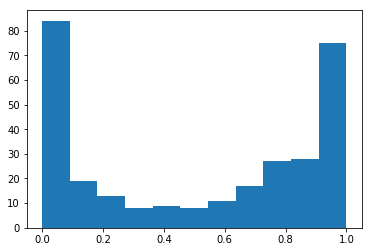

In [9]:
plt.hist(coverage_list, bins=np.linspace(0,1,12))
plt.show()

In [11]:
with open(PATH+'imgs_and_coverage.pth', 'wb') as f:
    pickle.dump((img_list, coverage_list), f, protocol=4)

In [3]:
with open(PATH+'imgs_and_coverage.pth', 'rb') as f:
    img_list, coverage_list = pickle.load(f)

In [15]:
from kural_core.models import *
from kural_core.data_processing import *

In [4]:
ds = CoverageDataset(img_list, coverage_list)
train_idx, val_idx = RandomIndicesForKFoldValidation(len(ds), 0, K=5, nORp=1)
bs = 50
clip = 50
train_dl = torch.utils.data.DataLoader(ds, batch_size=bs, sampler=SubsetSampler(train_idx, shuffle=True))
val_dl = torch.utils.data.DataLoader(ds, batch_size=bs, sampler=SubsetSampler(val_idx))
model = CoverageModel().cuda()
opt = torch.optim.Adam(model.parameters())
train_loss = []
val_loss = []
criterion = nn.L1Loss()

In [5]:
model.load_state_dict(torch.load(PATH+'coverage_model.pth'))

IncompatibleKeys(missing_keys=[], unexpected_keys=[])

In [6]:
model, _tl, _vl = train_model(model, train_dl, val_dl, opt, criterion, lr_start=1e-3, lr_end=None, epochs=200)
train_loss += _tl
val_loss += _vl

><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><
Spent 1m 55s doing 200 total steps for an average of 0.6s per step.
><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><


In [8]:
torch.save(model.state_dict(), PATH+'coverage_model.pth')

In [28]:
coverage_model = CoverageModel().cuda()
coverage_model.load_state_dict(torch.load(PATH_cm+'coverage_model.pth'))
coverage_model = coverage_model.eval()

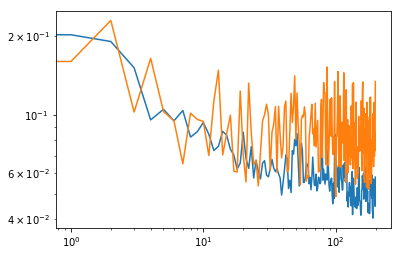

In [7]:
x = list(range(len(train_loss)))
# x = lr_range
slc = slice(0,len(train_loss))
plt.plot(x[slc],train_loss[slc])
plt.plot(x[slc],val_loss[slc])
plt.xscale('log')
plt.yscale('log')
# plt.ylim(.9, 2)
plt.show()

In [66]:
all_imgs = torch.stack(img_list)

In [14]:
torch.cuda.empty_cache()

In [78]:
score_list = model(all_imgs.cuda())

In [4]:
dumb=0
while dumb>=0:
    i = choice(all_imgs.shape[0])
    clear_output(True)
    plt.imshow(all_imgs[i,0])
    plt.title(f'actual: {coverage_list[i]} ~ predicted: {score_list[i]}')
    plt.show()
    dumb = input()

NameError: name 'all_imgs' is not defined

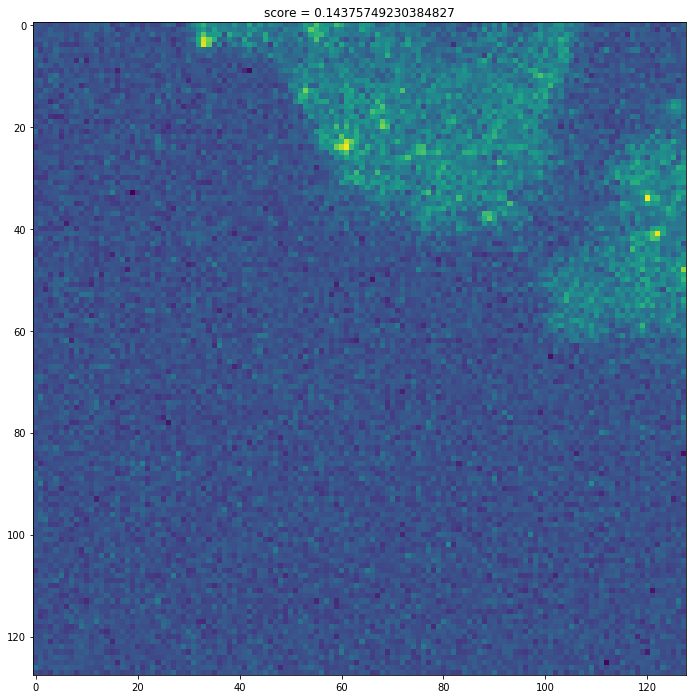

5


In [30]:
dumb=''
while dumb is '':
    rfov = choice(img_stream.metadata['fields_of_view'])
    rf = choice(img_stream.metadata['frames'])
    rz = choice(img_stream.metadata['z_levels'])
    img = img_stream.get_frame_2D(t=rf, v=rfov, z=rz)
    rx = choice(1200-128)
    ry = choice(1200-128)
    tmp_img = img[ry:ry+128, rx:rx+128].astype(np.float32)
    tmp_img = torch.tensor(tmp_img)
    tmp_img = (tmp_img-tmp_img.mean())/tmp_img.std()
    score = coverage_model(tmp_img[None, None].cuda())
#     score = model(tmp_img[None, None].cuda())
    clear_output(True)
    plt.imshow(tmp_img)
    plt.title(f'score = {score}')
    plt.show()
    dumb = input()

In [10]:
tic = time.perf_counter()
scores = np.zeros((1000,9))
for j in range(9):
    for i in range(1000):
        rfov = choice(img_stream.metadata['fields_of_view'])
        img = img_stream.get_frame_2D(t=j, v=rfov)
        rx = choice(1200-128)
        ry = choice(1200-128)
        tmp_img = img[ry:ry+128, rx:rx+128].astype(np.float32)
        tmp_img = torch.tensor(tmp_img)
        tmp_img = (tmp_img-tmp_img.mean())/tmp_img.std()
        score = coverage_model(tmp_img[None, None].cuda()).data.cpu().item()
        scores[i,j] = score
toc = time.perf_counter()
print(toc-tic)


183.188767893


In [25]:
score_hist = np.zeros((9,11))

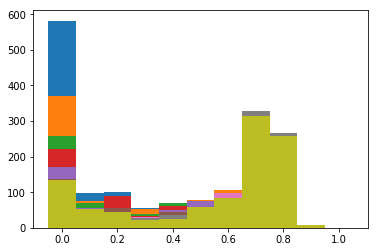

In [26]:
for i in range(9):
    y, x, patches = plt.hist(scores[:,i], bins=np.linspace(0,1.1,12)-.05)
    score_hist[i] = y

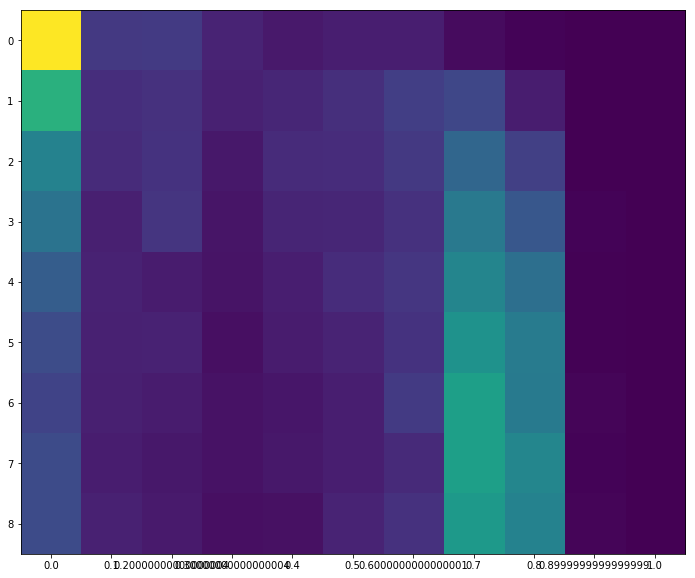

In [35]:
plt.figure(figsize=(16,10))
plt.imshow(score_hist)
ax = plt.gca()
ax.set_xticks(list(range(11)))
ax.set_xticklabels((x[:-1]+x[1:])/2)
# ax.set_aspect(30)
plt.show()

In [17]:
tic = time.perf_counter()
classes = []
imgs = torch.zeros((900, 1, 128, 128), dtype=torch.float32)
i = 0
j = 0
while True:
    rfov = choice(img_stream.metadata['fields_of_view'])
    img = img_stream.get_frame_2D(t=j, v=rfov)
    rx = choice(1200-128)
    ry = choice(1200-128)
    tmp_img = img[ry:ry+128, rx:rx+128].astype(np.float32)
    tmp_img = torch.tensor(tmp_img)
    tmp_img = (tmp_img-tmp_img.mean())/tmp_img.std()
    score = coverage_model(tmp_img[None, None].cuda()).data.cpu().item()
    if score>0.6:
        imgs[i,0] = tmp_img
        classes.append(j)
        i+=1
        if int(i//100-1) is j:
            j+=1
            print(time.perf_counter()-tic, j)
            if j is 9: break
classes = torch.tensor(classes)

31.853632596999887 1
38.69703775400012 2
42.46738053500121 3
45.19853828600026 4
47.979387018000125 5
50.43154863500058 6
52.52778765900075 7
54.57036298800085 8
56.643515409999964 9


In [59]:
tic = time.perf_counter()
classes = []
imgs = torch.zeros((800, 41, 128, 128), dtype=torch.float32)
i = 0
j = 0
while True:
    rfov = choice(img_stream.metadata['fields_of_view'])
    rx = choice(1200-128)
    ry = choice(1200-128)
    img_list = []
    for z in range(41):
        img = img_stream.get_frame_2D(t=j, v=rfov, z=z)
        tmp_img = img[ry:ry+128, rx:rx+128].astype(np.float32)
        tmp_img = torch.tensor(tmp_img)
        img_list.append(tmp_img)
    tmp_img = torch.stack(img_list)
    tmp_img = (tmp_img-tmp_img.mean())/tmp_img.std()
    score_list = coverage_model(tmp_img[:, None].cuda()).data.cpu().numpy()
    if max(score_list)>0.7:
        imgs[i,:] = tmp_img
        classes.append(j)
        i+=1
        if int(i//100-1) is j:
            j+=1
            print(time.perf_counter()-tic, j)
            if j is 8: break
classes = torch.tensor(classes)
classes = classes.float()/7
with open(PATH+'imgs_and_classes_zstacks_100_2.pickle', 'wb') as f:
    pickle.dump((imgs, classes), f, protocol=4)

11580.305228939003 1
19897.751408783995 2
27407.131079471 3
34476.898125966996 4
40428.317601475996 5
45404.095759093994 6
50652.131999813995 7
55319.011533601006 8


In [42]:
score_list = coverage_model(tmp_img[:,None].cuda()).data.cpu().numpy()
max(score_list)

-0.0032062456

In [46]:
with open(PATH+'imgs_and_classes_zstacks_100.pickle', 'wb') as f:
    pickle.dump((imgs, classes), f, protocol=4)

In [60]:
with open(PATH+'imgs_and_classes_zstacks_100.pickle', 'rb') as f:
    imgs2, classes2 = pickle.load(f)

In [62]:
classes2 = classes2.float()/7

In [53]:
classes = classes.float()/8

In [65]:
imgs_cat = torch.cat((imgs, imgs2))

In [66]:
imgs_cat.shape

torch.Size([1600, 41, 128, 128])

In [67]:
classes_cat = torch.cat((classes, classes2))

In [28]:
ds = ClassifierDataset(imgs, classes)
train_idx, val_idx = RandomIndicesForKFoldValidation(len(ds), 0, K=5, nORp=1)
bs = 200
clip = 50
train_dl = torch.utils.data.DataLoader(ds, batch_size=bs, sampler=SubsetSampler(train_idx, shuffle=True))
val_dl = torch.utils.data.DataLoader(ds, batch_size=2*bs, sampler=SubsetSampler(val_idx))
model = ActinClassifierModel(1).cuda()
opt = torch.optim.Adam(model.parameters())
train_loss = []
val_loss = []
accuracy = []
criterion = nn.MSELoss()

In [50]:
from kural_core.models import TimeAfterMitosisRegression3DModel

In [71]:
ds = ClassifierDataset(imgs_cat, classes_cat)
train_idx, val_idx = RandomIndicesForKFoldValidation(len(ds), 0, K=5, nORp=1)
bs = 40
clip = 50
train_dl = torch.utils.data.DataLoader(ds, batch_size=bs, sampler=SubsetSampler(train_idx, shuffle=True))
val_dl = torch.utils.data.DataLoader(ds, batch_size=bs, sampler=SubsetSampler(val_idx))
model = TimeAfterMitosisRegression3DModel(41).cuda()
opt = torch.optim.Adam(model.parameters())
train_loss = []
val_loss = []
accuracy = []
criterion = nn.MSELoss()

In [76]:
model, _tl, _vl = train_model(model, train_dl, val_dl, opt, criterion, lr_start=1e-3, epochs=100)
train_loss += _tl
val_loss += _vl
# accuracy += _ac

><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><
Spent 64m 28s doing 100 total steps for an average of 38.7s per step.
><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><


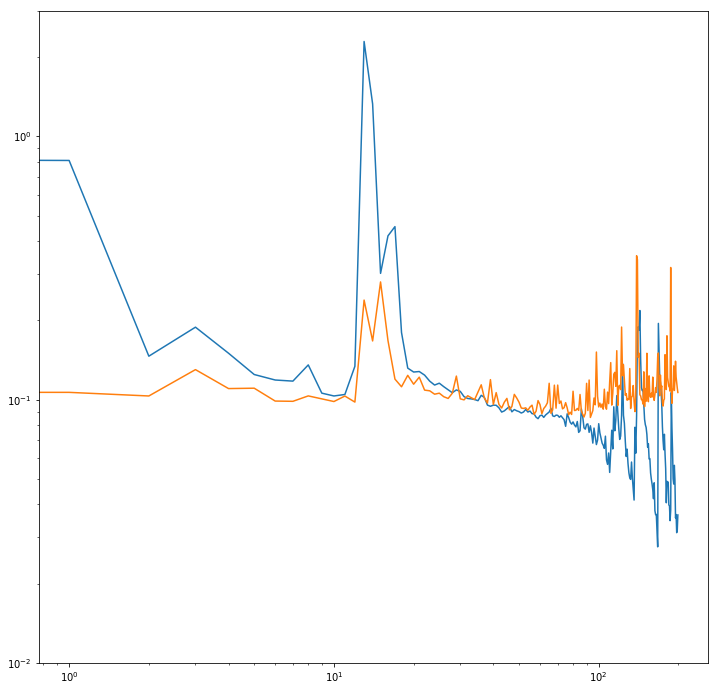

In [79]:
x = list(range(len(train_loss)))
# x = lr_range
slc = slice(0,len(train_loss))
plt.plot(x[slc], train_loss[slc])
plt.plot(x[slc], val_loss[slc])
# plt.plot(x[slc], accuracy[slc])
plt.xscale('log')
plt.yscale('log')
plt.ylim(.01, 3)
plt.show()

In [34]:
accuracy

[0.10222223,
 0.18166667,
 0.112222224,
 0.20333332,
 0.20888889,
 0.16444446,
 0.17833334,
 0.23999998,
 0.1261111,
 0.21111113,
 0.13666666,
 0.26277778,
 0.18666667,
 0.25444445,
 0.25055557,
 0.22999999,
 0.16277778,
 0.24722221,
 0.25388888,
 0.18555555,
 0.2422222,
 0.20555556,
 0.24444444,
 0.22777778,
 0.26666665,
 0.19666667,
 0.24166666,
 0.20555556,
 0.24666667,
 0.21777777,
 0.2,
 0.2383333,
 0.23222221,
 0.23555557,
 0.20833333,
 0.23444444,
 0.21944444,
 0.18111111,
 0.1938889,
 0.25388888,
 0.23555554,
 0.23833333,
 0.24055555,
 0.20166665,
 0.23111111,
 0.23499997,
 0.23222221,
 0.22833331,
 0.24277776,
 0.23444444,
 0.24722221,
 0.20666666,
 0.22,
 0.2372222,
 0.23222221,
 0.23111111,
 0.2261111,
 0.23166664,
 0.21833332,
 0.185,
 0.23333332,
 0.23611109,
 0.24833332,
 0.20277777,
 0.21222223,
 0.21833332,
 0.21388888,
 0.22111112,
 0.20277777,
 0.22388887,
 0.22388887,
 0.2383333,
 0.20277779,
 0.21055555,
 0.21388888,
 0.23166667,
 0.22388887,
 0.21499999,
 0.1811111

(array([203., 209., 187., 219., 190., 204., 187., 181., 220.]),
 array([-0.5,  0.5,  1.5,  2.5,  3.5,  4.5,  5.5,  6.5,  7.5,  8.5]),
 <a list of 9 Patch objects>)

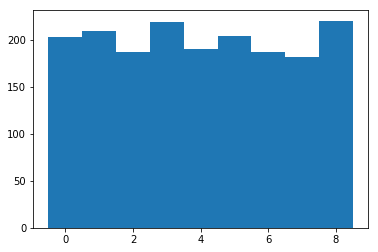

In [36]:
plt.hist(classes[val_idx], bins=np.linspace(0,9,10)-.5)